In [1]:
# import necessary library
from numpy.random import seed
seed(1000)
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
import shutil


from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.utils import shuffle

import keras
keras.__version__
from keras.api.models import Sequential
from keras.api.layers import Dense, Input, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Activation

import tensorflow
tensorflow.random.set_seed(1000)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator



In [2]:
# set up the directories
problem_base_dir = '/kaggle/input/histopathologic-cancer-detection'
problem_train_dir = problem_base_dir + '/train'
problem_test_dir = problem_base_dir + '/test'

# the image extension
ext = 'tif'

## Description of the problem/data

In this problem, the training data consists of image data along with labels, where 1 is assigned if the image corresponds to metastatic cancer and 0 otherwise.

The train_labels.csv file contains the image IDs and label data, with each ID corresponding to an image file in the train directory. These image files are stored in TIFF format.

Our goal is to determine whether each image in the test directory represents metastatic cancer and to maximize the ROC curve between the predicted probability and the observed target.

Given that this is medical imaging data, any data augmentation applied must consider realistic transformations. For example, certain asymmetric organs cannot be flipped horizontally or vertically.

Check the format of train_labels.csv, which contains the training data.

In [3]:
# load data
train_labels = pd.read_csv(f'{problem_base_dir}/train_labels.csv')
print(train_labels.info())
print(train_labels.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
None
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


Check the images for metastatic cancer. The images in the directory are in TIFF format, and the filenames seem to correspond to IDs.
Therefore, obtain and display the images labeled as 1 and 0 to inspect what kind of images they are.

In [4]:
def read_img(base_dir, name, cvt_color=cv2.COLOR_BGR2RGB):
    img_path = f'{base_dir}/{name}'
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cvt_color)
    return img

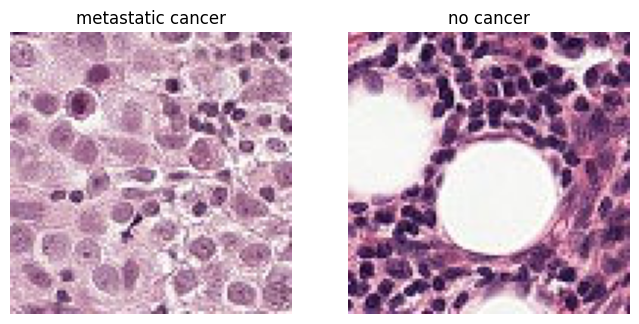

In [5]:
condition_cancer = train_labels.label == 1
condition_no_cancer = train_labels.label == 0
cancer_id = f'{train_labels[condition_cancer].sample(n=1, random_state=100).iloc[0,0]}'
no_cancer_id = f'{train_labels[condition_no_cancer].sample(n=1, random_state=100).iloc[0,0]}'

cancer_img = read_img(problem_train_dir, f'{cancer_id}.{ext}')
no_cancer_img = read_img(problem_train_dir, f'{no_cancer_id}.{ext}')

# show the images
def show_images(cancer_img, no_cancer_img):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 8))
    ax[0].imshow(cancer_img)
    ax[0].axis('off')
    ax[0].set_title('metastatic cancer')
    ax[1].imshow(no_cancer_img)
    ax[1].axis('off')
    ax[1].set_title('no cancer')
    fig.show()
show_images(cancer_img, no_cancer_img)

In [6]:
def show_image_information(base_dir, name):
    from PIL import Image
    img = Image.open(f'{base_dir}/{name}')
    width, height = img.size
    print(f'these images have width: {width}, height: {height}')
    print(f'these images are {img.mode}')
    print(f'these image format is {img.format}')

show_image_information(problem_train_dir, f'{cancer_id}.{ext}')

these images have width: 96, height: 96
these images are RGB
these image format is TIFF


Upon inspection, it was confirmed that the image size is 96 × 96, with the edges filled with a white margin. Additionally, the images are stored in RGB format.

Checking the folder, it was found that the dataset is quite large, with approximately 220,000 images for training and over 50,000 for testing. Therefore, it is evident that unpacking all images at once would be impractical.

## Exploratory Data Analysis (EDA)

First, the RGB components of the images labeled as "cancer" and "no cancer" will be plotted as histograms to investigate any potential patterns or trends.

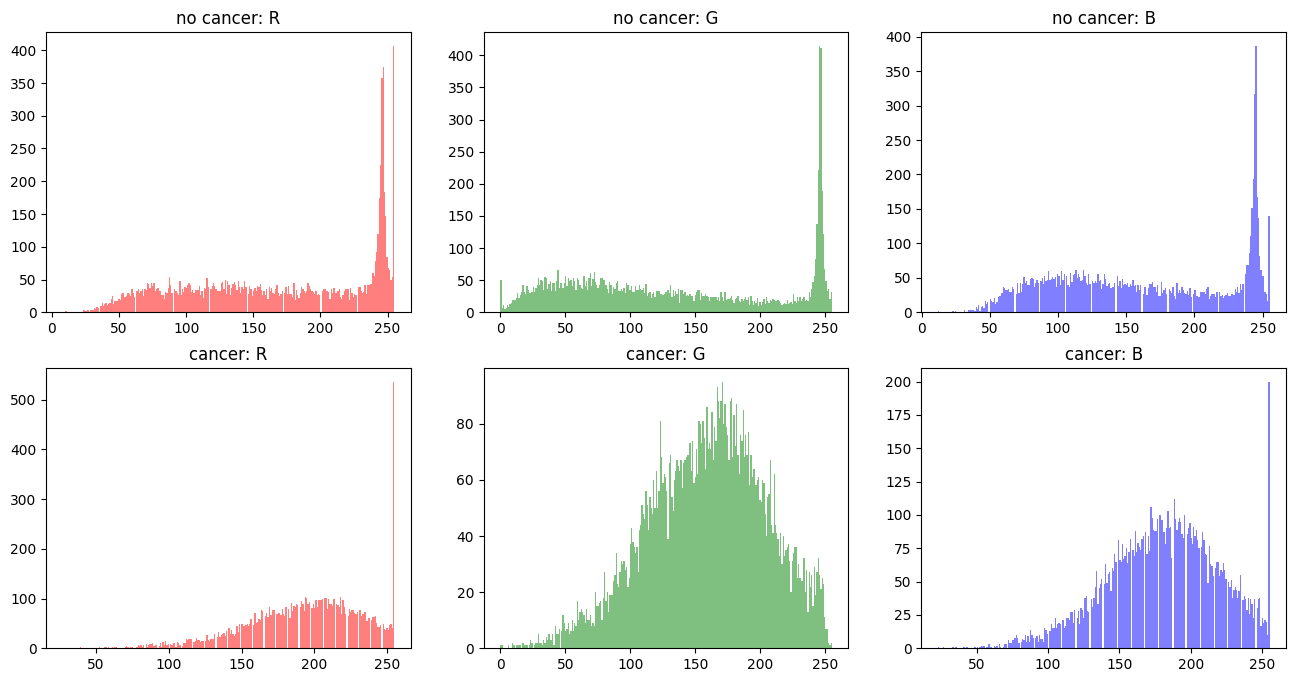

In [7]:
def compare_2img(no_cancer_img, cancer_img):
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))
    ax[0][0].set_title('no cancer: R')
    ax[0][0].hist(no_cancer_img[:, :, 0].ravel(), bins=256, color='red', alpha=0.5, label='Red')
    ax[0][1].set_title('no cancer: G')
    ax[0][1].hist(no_cancer_img[:, :, 1].ravel(), bins=256, color='green', alpha=0.5, label='Green')
    ax[0][2].set_title('no cancer: B')
    ax[0][2].hist(no_cancer_img[:, :, 2].ravel(), bins=256, color='blue', alpha=0.5, label='Blue')
    ax[1][0].set_title('cancer: R')
    ax[1][0].hist(cancer_img[:, :, 0].ravel(), bins=256, color='red', alpha=0.5, label='Red')
    ax[1][1].set_title('cancer: G')
    ax[1][1].hist(cancer_img[:, :, 1].ravel(), bins=256, color='green', alpha=0.5, label='Green')
    ax[1][2].set_title('cancer: B')
    ax[1][2].hist(cancer_img[:, :, 2].ravel(), bins=256, color='blue', alpha=0.5, label='Blue')
    plt.show()
compare_2img(no_cancer_img, cancer_img)

Comparing the histograms of the RGB components for images labeled as "cancer" and "no cancer," it was observed that the RGB values are generally detected at higher levels in cancer images compared to non-cancer images.

Next, we will check for any imbalance in the dataset between cancer and no cancer cases.

cancer images are 89117
no cancer images are 130908


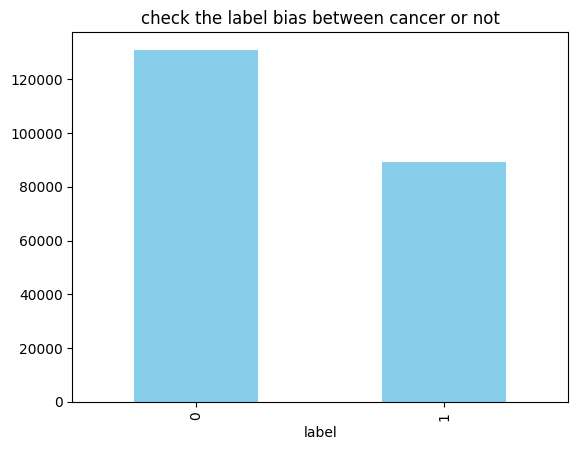

In [8]:
n_of_cancer = len(train_labels[condition_cancer])
n_of_no_cancer = len(train_labels[condition_no_cancer])
print(f'cancer images are {n_of_cancer}')
print(f'no cancer images are {n_of_no_cancer}')
train_labels.label.value_counts().plot(kind='bar', color='skyblue')
plt.title('check the label bias between cancer or not')
plt.show()

Although there are more "no cancer" images than "cancer" images, there does not appear to be an extreme imbalance in the dataset. However, there is an interest in balancing the number of images between the two categories.

In [9]:
SAMPLE_SIZE = 80000
train_labels_0 =  train_labels[condition_no_cancer].sample(n=SAMPLE_SIZE, random_state=1000)
train_labels_1 =  train_labels[condition_cancer].sample(n=SAMPLE_SIZE, random_state=1000)

train_data = pd.concat([train_labels_0, train_labels_1], axis=0).reset_index(drop=True)
# randomize the data set
train_data = shuffle(train_data)

print(train_data.label.value_counts())

label
1    80000
0    80000
Name: count, dtype: int64


Split the data into training and test sets while maintaining a consistent label ratio.

In [10]:
train_df, valid_df = train_test_split(train_data, test_size=0.10, random_state=1000, stratify=train_data.label)

print(train_df.shape)
print(valid_df.shape)
print(train_df.label.value_counts())
print(valid_df.label.value_counts())

(144000, 2)
(16000, 2)
label
1    72000
0    72000
Name: count, dtype: int64
label
1    8000
0    8000
Name: count, dtype: int64


For data analysis, organize the images into a specific directory. First, create the directory in the current workspace.

In [11]:
BASE_DIR = 'histopathologic_cancer_detection'
TRAIN_DIR = 'train'
VALID_DIR = 'valid'
TEST_DIR = 'test'
NO_CANCER_DIR = '00_no_cancer'
CANCER_DIR = '01_cancer'
CLASSIFY_DIR = 'images'
os.makedirs(BASE_DIR, exist_ok=True)
# create train directory
train_dir = os.path.join(BASE_DIR, TRAIN_DIR)
train_no_cancer_dir = os.path.join(train_dir, NO_CANCER_DIR)
train_cancer_dir = os.path.join(train_dir, CANCER_DIR)
os.makedirs(train_no_cancer_dir, exist_ok=True)
os.makedirs(train_cancer_dir, exist_ok=True)

# create validation directory
valid_dir = os.path.join(BASE_DIR, VALID_DIR)
valid_no_cancer_dir = os.path.join(valid_dir, NO_CANCER_DIR)
valid_cancer_dir = os.path.join(valid_dir, CANCER_DIR)
os.makedirs(valid_no_cancer_dir, exist_ok=True)
os.makedirs(valid_cancer_dir, exist_ok=True)

# create test directory
test_dir = os.path.join(BASE_DIR, TEST_DIR)
os.makedirs(test_dir, exist_ok=True)
test_images_dir = os.path.join(test_dir, CLASSIFY_DIR)
os.makedirs(test_images_dir, exist_ok=True)

Since the directory has been created, the next step is to move the target images into this directory.

In [12]:
train_data.set_index('id', inplace=True)
train_id_list = list(train_df.id)
valid_id_list = list(valid_df.id)

def copy_img_to_dir(df, id_list, src_dir, dest_dir):
    for image_id in id_list:
        file_name = f'{image_id}.{ext}'
        label = df.loc[image_id,'label']
        
        if label == 0:
            directory = NO_CANCER_DIR
        else: # label == 1
            directory = CANCER_DIR
        
        src = os.path.join(src_dir, file_name)
        dst = os.path.join(dest_dir, directory, file_name)
        shutil.copyfile(src, dst)
copy_img_to_dir(train_data, train_id_list, problem_train_dir, train_dir)
copy_img_to_dir(train_data, valid_id_list, problem_train_dir, valid_dir)

In [13]:
test_filenames = [filename for filename in os.listdir(problem_test_dir)]
for filename in test_filenames:
    src = os.path.join(problem_test_dir, filename)
    dst = os.path.join(test_images_dir, filename)
    shutil.copyfile(src, dst)

In [14]:
print(len(os.listdir(train_no_cancer_dir)))
print(len(os.listdir(train_cancer_dir)))
print(len(os.listdir(valid_no_cancer_dir)))
print(len(os.listdir(valid_cancer_dir)))
print(len(os.listdir(test_images_dir)))

72000
72000
8000
8000
57458


## Model Architecture

The approach will proceed as follows.
First, we will check what happens when a baseline model without Convolutional Neural Networks (CNNs) is used.
Then, we will utilize CNNs to create and compare model architectures with 1, 2, and 3 layers.

The architectures of the models are as follows:

- Model1: In -> Flatten() -> Dense(256) -> Dropout(0.3) -> out
- Model2: In -> [Conv2D * 2 -> Maxpool2D(0.3) -> Dropout(0.3)] * 1 (filter=32) -> Flatten() -> Dense(256) -> Dropout(0.3) -> out
- Model3: In -> [Conv2D * 2 -> Maxpool2D(0.3) -> Dropout(0.3)] * 2 (filter=32, 64) -> Flatten() -> Dense(256) -> Dropout(0.3) -> out
- Model4: In -> [Conv2D * 2 -> Maxpool2D(0.3) -> Dropout(0.3)] * 3 (filter=32, 64, 128) -> Flatten() -> Dense(256) -> Dropout(0.3) -> out
For the final output, since a binary output is required, a sigmoid function is used. The activation function for all other layers is ReLU. The Adam optimizer is used as the loss function, with a learning rate of 0.01.

My expectation is that, given the complexity of the images, the accuracy will improve with more CNN layers that retain the features. However, to prevent overfitting, I have included Dropout and BatchNormalization after each Conv2D operation for regularization.

Set up the generator to use the images.

In [15]:
n_of_train_samples = len(train_df)
n_of_valid_samples  = len(valid_df)
train_batch_size = 32
valid_batch_size = 32
image_width = 96
image_height = 96

train_steps = int(np.ceil(n_of_train_samples / train_batch_size))
valid_steps = int(np.ceil(n_of_valid_samples / valid_batch_size))

data_generator = ImageDataGenerator(rescale=1./255)
train_gen = data_generator.flow_from_directory(train_dir,
                                               target_size=(image_width,image_height),
                                               batch_size=train_batch_size,
                                               class_mode='binary',
                                               seed=100
                                               )
valid_gen = data_generator.flow_from_directory(valid_dir,
                                               target_size=(image_width,image_height),
                                               batch_size=valid_batch_size,
                                               class_mode='binary',
                                               seed=100
                                              )
test_gen = data_generator.flow_from_directory(valid_dir,
                                              target_size=(image_width,image_height),
                                              batch_size=1,
                                              class_mode='binary',
                                              seed=100,
                                              shuffle=False)

Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.


In [16]:
height = 96
width = 96
channel = 3 # R, G, B
model = Sequential()
model.add(Input(shape=(height, width, channel)))

model.add(Flatten())
model.add(Dense(units = 256))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(rate = 0.3))

model.add(Dense(units = 1, activation = 'sigmoid'))
model.summary()

model.compile(Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 27648)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       7,078,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,079,425 (27.01 MB)

 Trainable params: 7,078,913 (27.00 MB)

 Non-trainable params: 512 (2.00 KB)

In [ ]:
history = model.fit(train_gen,
          epochs=10,
          validation_data=valid_gen,
          verbose=1)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4500/4500 ━━━━━━━━━━━━━━━━━━━━ 130s 28ms/step - accuracy: 0.7054 - loss: 0.5965 - val_accuracy: 0.5407 - val_loss: 1.0550
Epoch 2/10
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 123s 27ms/step - accuracy: 0.7347 - loss: 0.5446 - val_accuracy: 0.6143 - val_loss: 0.8344
Epoch 3/10
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 123s 27ms/step - accuracy: 0.7423 - loss: 0.5318 - val_accuracy: 0.5990 - val_loss: 0.8027
Epoch 4/10
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 123s 27ms/step - accuracy: 0.7494 - loss: 0.5239 - val_accuracy: 0.6206 - val_loss: 0.6973
Epoch 5/10
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 122s 27ms/step - accuracy: 0.7547 - loss: 0.5168 - val_accuracy: 0.6892 - val_loss: 0.6542
Epoch 6/10
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 124s 27ms/step - accuracy: 0.7653 - loss: 0.5025 - val_accuracy: 0.7246 - val_loss: 0.5451
Epoch 7/10
3099/4500 ━━━━━━━━━━━━━━━━━━━━ 34s 25ms/step - accuracy: 0.7683 - loss: 0.4961

In [ ]:
# setup the parameter to be used.
first_filter = 32
second_filter = 64
third_filter = 128
kernel_size = (3, 3)
pool_size = (2, 2)

In [ ]:
model2 = Sequential()
model2.add(Input(shape=(height, width, channel)))

model2.add(Conv2D(first_filter, kernel_size, strides=1))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Conv2D(first_filter, kernel_size, strides=1))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size = pool_size))
model2.add(Dropout(rate = 0.3))

model2.add(Flatten())
model2.add(Dense(units = 256))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(Dropout(rate = 0.3))

model2.add(Dense(units = 1, activation = 'sigmoid'))
model2.summary()

model2.compile(Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history2 = model2.fit(train_gen,
          epochs=10,
          validation_data=valid_gen,
          verbose=1)

In [ ]:
model3 = Sequential()
model3.add(Input(shape=(height, width, channel)))

model3.add(Conv2D(first_filter, kernel_size, strides=1))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(Conv2D(first_filter, kernel_size, strides=1))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size = pool_size))
model3.add(Dropout(rate = 0.3))

model3.add(Conv2D(second_filter, kernel_size, strides=1))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(Conv2D(second_filter, kernel_size, strides=1))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size = pool_size))
model3.add(Dropout(rate = 0.3))

model3.add(Flatten())
model3.add(Dense(units = 256))
model3.add(BatchNormalization())
model3.add(Activation("relu"))
model3.add(Dropout(rate = 0.3))
model3.add(Dense(units = 1, activation = 'sigmoid'))

model3.summary()
model3.compile(Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history3 = model3.fit(train_gen,
          epochs=10,
          validation_data=valid_gen,
          verbose=1)

In [ ]:
model4 = Sequential()
model4.add(Input(shape=(height, width, channel)))

model4.add(Conv2D(first_filter, kernel_size, strides=1))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(Conv2D(first_filter, kernel_size, strides=1))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(MaxPooling2D(pool_size = pool_size))
model4.add(Dropout(rate = 0.3))

model4.add(Conv2D(second_filter, kernel_size, strides=1))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(Conv2D(second_filter, kernel_size, strides=1))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(MaxPooling2D(pool_size = pool_size))
model4.add(Dropout(rate = 0.3))

model4.add(Conv2D(third_filter, kernel_size, strides=1))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(Conv2D(third_filter, kernel_size, strides=1))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(MaxPooling2D(pool_size = pool_size))
model4.add(Dropout(rate = 0.3))

model4.add(Flatten())
model4.add(Dense(units = 256))
model4.add(BatchNormalization())
model4.add(Activation("relu"))
model4.add(Dropout(rate = 0.3))
model4.add(Dense(units = 1, activation = 'sigmoid'))

model4.summary()
model4.compile(Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history4 = model4.fit(train_gen,
          epochs=10,
          validation_data=valid_gen,
          verbose=1)

The accuracy and loss of each model will be plotted.

In [ ]:
def show_history(histories):
    n = len(histories)
    fig, ax = plt.subplots(nrows=n, ncols=2, figsize=(16, 16))
    for i in range(n):
        history = histories[i]
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        ax[i][0].plot(range(1, len(loss) + 1), loss, 'b', label='Train loss')
        ax[i][0].plot(range(1, len(val_loss) + 1), val_loss, 'r', label='Validation loss')
        ax[i][0].set_title('loss', fontsize=16)
        ax[i][0].legend()
        ax[i][1].plot(range(1, len(acc) + 1), acc, 'b', label='train accuracy')
        ax[i][1].plot(range(1, len(val_acc) + 1), val_acc, 'r', label='validation accuracy')
        ax[i][1].set_title('accuracy', fontsize=16)
        ax[i][1].legend()
    plt.show()
        
    
show_history([history, history2, history3, history4])

Furthermore, the ROC curve for each model will be plotted using the validation images.

In [ ]:
# ROC 
def show_roc(models, generator, dataframe):
    n = len(models)
    fig, ax = plt.subplots(nrows=1, ncols=n, figsize=(8,4))
    for i in range(n):
        model = models[i]
        y_true = generator.labels
        y_pred = model.predict(generator, steps=len(generator), verbose=True)
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        x = auc(fpr, tpr)
        ax[i].plot([0, 1], [0, 1], 'k--')
        ax[i].plot(fpr, tpr, label=f'area = {x:.3f}')
        ax[i].legend()
        ax[i].set_title(f'ROC curve (model {i + 1})')
    plt.show()


show_roc([model, model2, model3, model4], test_gen, valid_df)

## Result & Analysis

Examining the execution results of each model, we can see from the loss and accuracy of both the training and validation data that Model 1, which lacks the baseline CNN, tends to show a decrease in validation accuracy compared to training accuracy. This indicates that overfitting is occurring.

On the other hand, in the cases of Models 2 to 4, the accuracy is not stable, which may suggest that the learning rate is too high.

Additionally, when checking the ROC, it is evident that models with a three-layer CNN have a higher ROC curve.

The submission results for each model are shown below.

In [ ]:
train_batch_size = 32
valid_batch_size = 32
image_width = 96
image_height = 96
data_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = data_generator.flow_from_directory(test_dir,
                                                          target_size=(image_width,image_height),
                                                          batch_size=128,
                                                          class_mode='binary',
                                                          shuffle=False
                                                          )

In [ ]:
def create_submission_csv(models):
    n = len(models)
    for i in range(n):
        model = models[i]
        predictions = model.predict(test_image_generator, steps=test_image_generator.samples ,verbose=True)
        ids = [os.path.splitext(os.path.basename(filename))[0] for filename in test_image_generator.filenames]
        y_preds = (predictions > 0.5).astype(int).reshape(-1)
        submission = pd.DataFrame({
            'id': ids,
            'label': y_preds
        })
        submission.to_csv(f'submission_model{i+1}.csv', index=False)
create_submission_csv([model, model2, model3, model4])


| Model  | Private Score | Public Score |
|--------|---------------|--------------|
| model1 | 0.5406        | 0.5420       |
| model2 | 0.7196        | 0.7757       |
| model3 | 0.6832        | 0.7087       |
| model4 | 0.8294        | 0.8903       |

## Discussion/Conclusion

Discuss and interpret results as well as learnings and takeaways. 

What did and did not help improve the performance of your models?

What improvements could you try in the future?

Machine learning using image data clearly performs better when utilizing CNNs, and it has been observed that increasing the number of layers improves the ROC.

Only normalization (1./255) was applied using ImageDataGenerator, but testing other techniques such as zoom, horizontal flip, rotation range, and vertical flip may further enhance performance.

Additionally, in this experiment, the drop rate was fixed at 0.3, but fine-tuning each layer individually might yield even better results.

## Reference
- https://www.kaggle.com/code/vbookshelf/cnn-how-to-use-160-000-images-without-crashing
- https://www.kaggle.com/code/fmarazzi/baseline-keras-cnn-roc-fast-10min-0-925-lb#Baseline-Keras-CNN-with-160k-samples
- https://www.kaggle.com/code/akarshu121/cancer-detection-with-cnn-for-beginners